<a href="https://colab.research.google.com/github/eunhaday/AIFFEL_quest_cr/blob/master/AIFFELTHON_PRJ/billiards_route.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#기존에 생성한 폴더를 삭제하는 경우
#!rm -rf "/content/drive/MyDrive/Billiard"

# 라이브러리 추가

In [ ]:
# pip를 사용하여 Ultralytics 설치
!pip install ultralytics
!pip install stable-baselines3[extra]
!pip install shimmy

In [ ]:
from ultralytics import YOLO
import cv2
import os
import pandas as pd
import math
from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab
import gym
import numpy as np
from gym import spaces
from stable_baselines3 import PPO

# 1. 동영상 데이터 전처리
## 1-1. 프레임추출
#### 동영상을 프레임으로 분리하고, 프레임 간의 움직임을 감지하여 샷 구간만 추출

In [ ]:
#import cv2
#import os

def extract_shot_frames(video_path, output_dir, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    os.makedirs(output_dir, exist_ok=True)
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # 프레임 간격 설정
        if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) % frame_interval == 0:
            cv2.imwrite(os.path.join(output_dir, f"frame_{frame_count}.jpg"), frame)
            frame_count += 1
    cap.release()
    print(f"Extracted {frame_count} frames.")

extract_shot_frames("/content/drive/MyDrive/billiard_game.mp4", "/content/drive/MyDrive/Billiard/Input_mp4/frames", frame_interval=10)


Extracted 1029 frames.


## 1-2. 공 및 큐 탐지

In [ ]:
from ultralytics import YOLO  # YOLO object detection model
import cv2
import os
import pandas as pd

# Load the pre-trained YOLO model
model = YOLO("yolov8n.pt")

# Perform object detection on image frames in a directory and save results to a CSV
def detect_objects_in_frames(input_dir, output_file):
    results = []
    for frame in os.listdir(input_dir):
        frame_path = os.path.join(input_dir, frame)
        img = cv2.imread(frame_path)  # Read each frame using OpenCV

        # Perform object detection
        detections = model(img)  # YOLO detection on the image

        # Process detection results
        for box in detections[0].boxes:  # Access detected objects
            cls = int(box.cls)  # Class ID
            conf = float(box.conf)  # Confidence score
            x, y, w, h = box.xyxy[0].cpu().numpy()  # 경계 상자 좌표 추출  #box.xywh.tolist()[0]  # Bounding box center (x, y), width, and height

            # Append detection details to the results list
            results.append({
                'frame': frame,
                'class': cls,       # Class ID (e.g., 0: cue ball, 1: target ball)
                'x': x, 'y': y,     # Bounding box center coordinates
                'w': w, 'h': h,     # Bounding box dimensions
                'confidence': conf  # Confidence score
            })

    # Save results to a CSV file
    pd.DataFrame(results).to_csv(output_file, index=False)

# Run the detection function
detect_objects_in_frames(
    "/content/drive/MyDrive/Billiard/Input_mp4/frames",
    "/content/drive/MyDrive/Billiard/my_detections.csv"
)



0: 384x640 1 person, 1 sports ball, 1 tv, 180.7ms
Speed: 7.8ms preprocess, 180.7ms inference, 4.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 1 tv, 182.3ms
Speed: 4.9ms preprocess, 182.3ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 1 tv, 172.9ms
Speed: 5.7ms preprocess, 172.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 1 tv, 161.4ms
Speed: 5.2ms preprocess, 161.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 sports ball, 1 tv, 172.0ms
Speed: 5.0ms preprocess, 172.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 sports ball, 1 tv, 1 laptop, 154.6ms
Speed: 4.2ms preprocess, 154.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 tv, 168.1ms
Speed: 5.7ms preprocess, 168.1ms inference, 1.2ms postprocess per image at shape

## 1-3. 데이터 준비

In [ ]:
import pandas as pd

# Load the detection data
detections = pd.read_csv("/content/drive/MyDrive/Billiard/my_detections.csv")

# Organize data by shots
shots = []
for frame in detections['frame'].unique():
    frame_data = detections[detections['frame'] == frame]
    #print('frame1:', frame)
    #print('class:',detections['class'])

    # Initialize positions with None in case the object is not detected
    cue_ball = frame_data[frame_data['class'] == 0]
    target1 = frame_data[frame_data['class'] == 1]
    target2 = frame_data[frame_data['class'] == 2]

    # Extract positions if the object exists, otherwise set to None
    cue_ball_pos = (cue_ball.iloc[0]['x'], cue_ball.iloc[0]['y']) if not cue_ball.empty else None
    target1_pos = (target1.iloc[0]['x'], target1.iloc[0]['y']) if not target1.empty else None
    target2_pos = (target2.iloc[0]['x'], target2.iloc[0]['y']) if not target2.empty else None

    # Append the shot data
    shots.append({
        #'frame': frame,
        'shot': f"Shot {len(shots) + 1}",
        'data': {'cue_ball': cue_ball_pos, 'target1': target1_pos, 'target2': target2_pos}
    })

# Prepare data for CSV
csv_data = [
    #{'frame': shot['frame'], 'shot': shot['shot'], 'data': shot['data']} for shot in shots
    {'shot': shot['shot'], 'data': shot['data']} for shot in shots
]

# Save to CSV
output_file = "/content/drive/MyDrive/Billiard/shots_summary.csv"
pd.DataFrame(csv_data).to_csv(output_file, index=False)

print(f"Data saved to {output_file}")


Data saved to /content/drive/MyDrive/Billiard/shots_summary.csv


## 2.강화학습 환경 설계
### 2-1. 환경 정의
OpenAI Gym을 사용하여 강화학습 환경생성

In [ ]:
#import gym
#import numpy as np
#from gym import spaces

class BilliardsEnv(gym.Env):
    def __init__(self):
        super(BilliardsEnv, self).__init__()
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([360, 1]), dtype=np.float32)  # 각도, 힘
        self.observation_space = spaces.Box(low=0, high=1, shape=(6,), dtype=np.float32)  # 상태: 큐볼, 목적구 1, 2 위치

    def reset(self):
        self.state = np.random.rand(6)  # 큐볼(x, y), 목적구1(x, y), 목적구2(x, y)
        return self.state

    def step(self, action):
        angle, force = action
        # 물리 모델로 결과 계산 (충돌, 쿠션 등)
        reward = self._compute_reward()
        done = reward > 5  # 성공 기준
        return self.state, reward, done, {}

    def _compute_reward(self):
        # 목표 공 두 개를 맞췄는지 계산
        return np.random.rand() * 10

env = BilliardsEnv()


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


## 2-2. 모델 학습

#### PPO 알고리즘으로 큐볼의 최적 경로를 학습

In [ ]:
#from stable_baselines3 import PPO

# PPO 모델 학습
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100000)
model.save("/content/drive/MyDrive/Billiard/ppo_billiards")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.81     |
|    ep_rew_mean     | 9.43     |
| time/              |          |
|    fps             | 1023     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.04        |
|    ep_rew_mean          | 10.4        |
| time/                   |             |
|    fps                  | 681         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.001831236 |
|    clip_fraction        | 0.00898     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | -0.00161    |
|    learning_rate        | 0.

## 3. 학습된 데이터로 예측 경로 출력
### 3-1.예측 결과 계산
#### 학습된 모델을 사용하여 상태에서 최적의 행동을 예측

In [ ]:
model = PPO.load("/content/drive/MyDrive/Billiard/ppo_billiards.zip")

# 초기 상태 설정
state = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])  # 큐볼, 목적구 위치
action, _ = model.predict(state)  # 최적 행동(각도, 힘) 예측

# 결과 출력
print(f"Recommended action: Angle={action[0]}, Force={action[1]}")

Recommended action: Angle=1.1515121459960938, Force=1.0


### 3.2 경로 시각화
#### OpenCV로 예측된 경로를 프레임 위에 그려주기

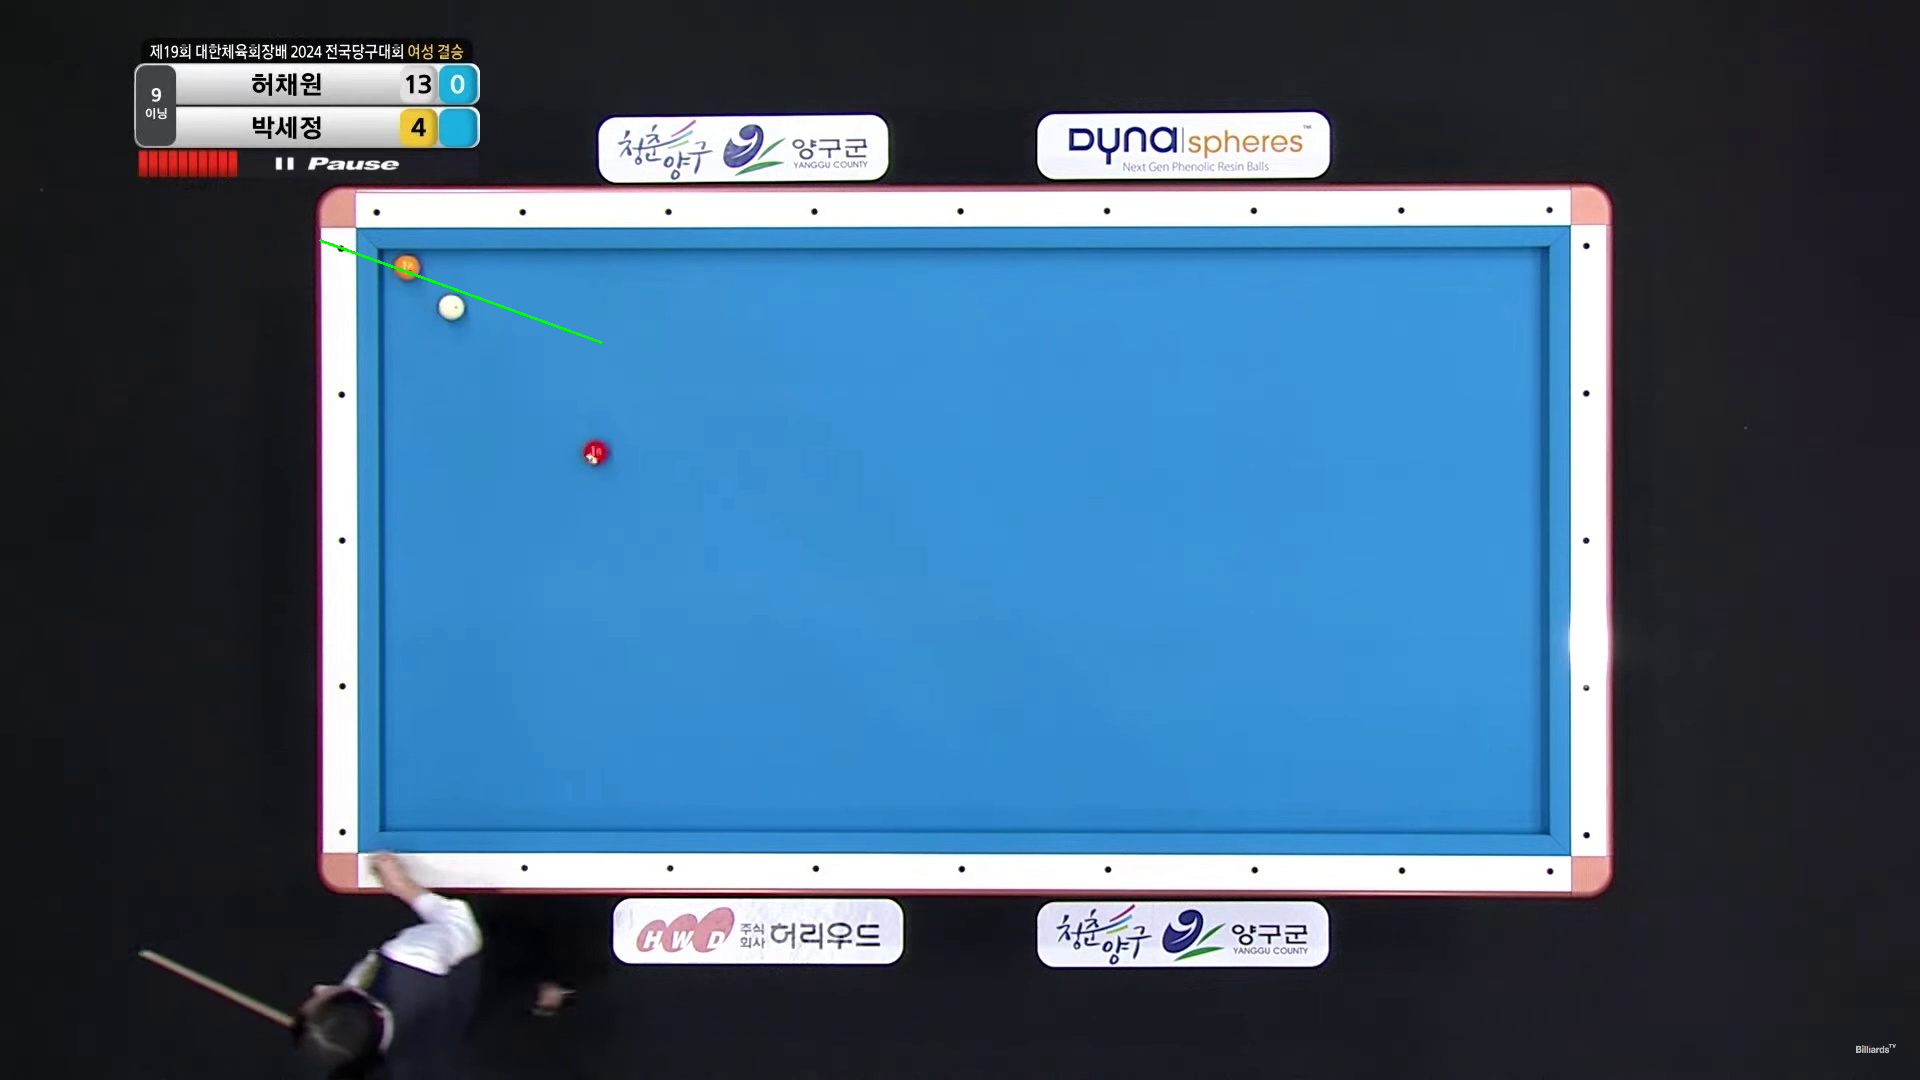

In [ ]:
#import cv2
#import math
#from google.colab.patches import cv2_imshow # Import cv2_imshow for Colab

def draw_predicted_path(frame, cue_ball, angle, force):
    x, y = cue_ball
    dx = force * math.cos(math.radians(angle))
    dy = force * math.sin(math.radians(angle))
    end_x, end_y = int(x + dx), int(y + dy)
    cv2.line(frame, (int(x), int(y)), (end_x, end_y), (0, 255, 0), 2)
    return frame

frame = cv2.imread("/content/drive/MyDrive/Billiard/Input_mp4/frames/frame_102.jpg")
cue_ball = (320, 240)
#predicted_frame = draw_predicted_path(frame, cue_ball, angle=45, force=100)
predicted_frame = draw_predicted_path(frame, cue_ball, angle=20, force=300)

cv2_imshow(predicted_frame) # Use cv2_imshow instead of cv2.imshow
#cv2.waitKey(0)